# ENSF611 Final Project

## Project Description

In [12]:
# Installed some required libraries
!pip install ucimlrepo


Defaulting to user installation because normal site-packages is not writeable


## Import required elements

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier




## Load the data

In [14]:
phiusiil_phishing_url_website = fetch_ucirepo(id=967)

X_full = phiusiil_phishing_url_website.data.features.copy()
y_full = phiusiil_phishing_url_website.data.targets.copy()

target_col = y_full.columns[0]
df = pd.concat([X_full, y_full], axis=1)

drop_cols = [target_col]
for col in ["FILENAME", "FileName", "file_name"]:
    if col in df.columns:
        drop_cols.append(col)

X_full = df.drop(columns=drop_cols)
y_full = df[target_col]




## Splitting the data

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

train_numeric = X_train.select_dtypes(include=["int64", "float64"])
corr_with_target = train_numeric.corrwith(y_train.squeeze()).abs()
threshold = 0.05
selected_numeric_features = corr_with_target[corr_with_target >= threshold].index.tolist()

train_categorical_features = X_train.select_dtypes(include=["object", "bool"]).columns.tolist()

X_train = X_train[selected_numeric_features + train_categorical_features]
X_test = X_test[selected_numeric_features + train_categorical_features]

numeric_selected_train = X_train[selected_numeric_features]




## Visualize the correlation between the data

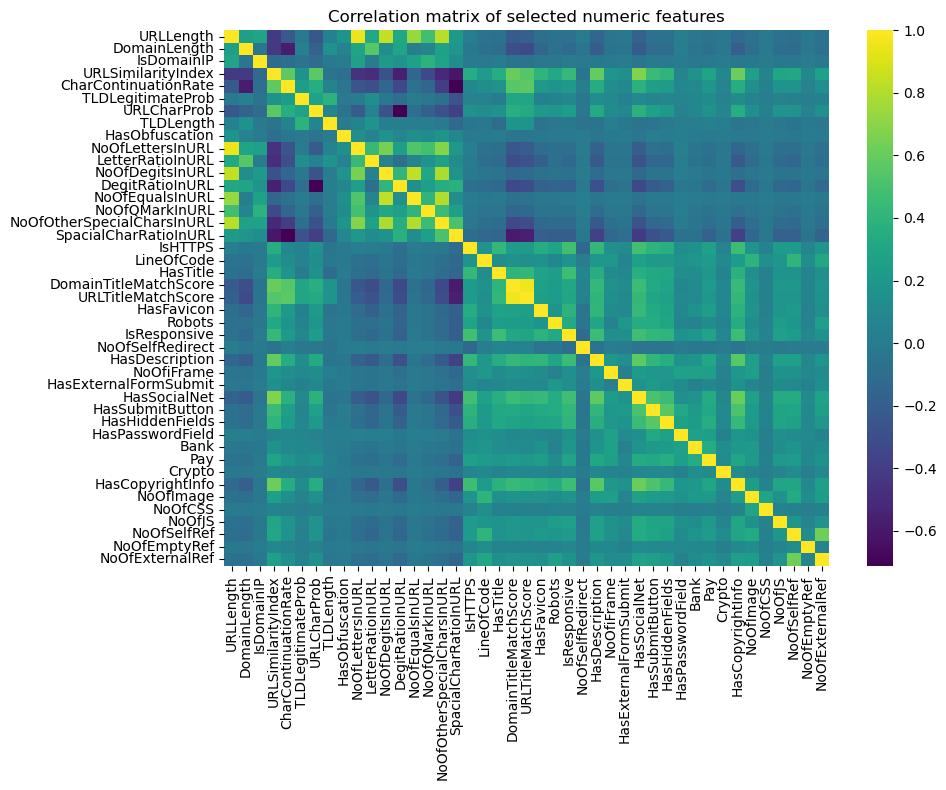

In [16]:
plt.figure(figsize=(10, 8))
sns.heatmap(train_numeric[selected_numeric_features].corr(), cmap="viridis")
plt.title("Correlation matrix of selected numeric features")
plt.tight_layout()
plt.show()

## Create scaler, Encoder and Column Transformer

In [17]:
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object", "bool"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


## Model Declaration

In [18]:
models = {
    "knn": KNeighborsClassifier(),
    "RF": RandomForestClassifier()
}
param_grids = {
    "knn": {
        "clf__n_neighbors": [3, 5, 11],
        "clf__weights": ["uniform", "distance"],
        "clf__metric": ["minkowski", "manhattan"]
    },
    "RF": {
        "RF__n_estimators": [100, 250, 500, 1000],
        "RF__criterion": ["gini", "entropy"],
        "RF__min_samples_split": [2, 5, 10]
    }
}
best_models = {}
results = []

## Training the model & Gathering metrics

In [19]:
for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("clf", model)
    ])
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[name],
        cv=3,
        scoring="f1",
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    y_pred = grid.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append({
        "model": name,
        "best_params": grid.best_params_,
        "test_accuracy": acc,
        "test_precision": prec,
        "test_recall": rec,
        "test_f1": f1
    })

results_df = pd.DataFrame(results)
print(results_df)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


KeyboardInterrupt: 

## Plot confusion matrix

In [ ]:
def plot_confusion_matrix(cm, classes, title):
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.title(title)
    plt.tight_layout()
    plt.show()

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    print(name.upper())
    print(classification_report(y_test, y_pred, digits=4))
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(
        cm,
        ["phishing (0)", "legitimate (1)"],
        f"{name.upper()} - Confusion Matrix"
    )

metrics_to_plot = ["test_accuracy", "test_precision", "test_recall", "test_f1"]

plt.figure(figsize=(8, 5))
for metric in metrics_to_plot:
    plt.plot(
        results_df["model"],
        results_df[metric],
        marker="o",
        label=metric.replace("test_", "").capitalize()
    )


In [ ]:

plt.ylim(0.5, 1.0)
plt.title("Model Comparison on Test Set")
plt.xlabel("Model")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

results_df.sort_values("test_f1", ascending=False)